This is an updated version of this file, with the suggestions done by cyang-kth already implemented. 
https://github.com/cyang-kth/fmm/issues/70

# imports

In [1]:
from pylab import *
import pandas as pd
import geopandas as gpd
import networkx as nx

%config Completer.use_jedi = False 
# %matplotlib notebook
%matplotlib inline

import myMatcher as MM

import importlib
importlib.reload(MM)

<module 'myMatcher' from '/home/christianweber/python_GIT/Maptech/MapMatching/fmm/standalone/myMatcher.py'>

# collect some functions

In [23]:
def mm_load(shp_):
    importlib.reload(MM)
    mm = MM.myMatcher(p_unx='./', p_nw='./')
    mm.load_network(shp_ = shp_)
    mm.load_data_shp("./data/syntetic_data_ANV_UTM.shp")
    mm.generate_lineString()
    return mm

def config_match_plot(mm, k=8, d=10, radius=20, factor=15, gps_error=50, with_params=False):
    #config
    if d>0:
        mm.reduce_trajectory(d=d)
        mm.wkt = mm.gdf_lineString.iloc[0].ls_ip.wkt
    else:
        mm.wkt = mm.gdf_lineString.iloc[0].geometry.wkt
    mm.config_matcher(radius=radius, k=k, factor=factor, gps_error=gps_error, )
    #match
    mm.match_wkt()
    #plot
    mm.plot(zoom_=True, with_params=with_params)    
    return mm

# directed vs not directed network

In [31]:
shp_directed = 'data/bike_centerline_v1_extract_ANVedges_source_target.shp'
shp_undirected = 'data/bike_centerline_v1_extract_ANVedges_source_target_rev.shp'

# shp_ = shp_directed
shp_ = shp_undirected

In an earlier version of this work, I only swapped source-target in the network shapefile, in order to generate the "undirected" network. This, however, does not affect the direction of the lineString itself, so STMATCH was trying to match an impossible network (and failed, naturally). <br>
For reference, both networks are stored here, and we can observe the behavior by loading the directed (i.e. only one direction per lineString, but source-targed swapped) and the undirected network (source-target not swapped, but lineString direction reversed in the second half of the dataframe). 

# Network topology

The network is bidirectional, as an example we look at one edge:

In [32]:
mm = mm_load(shp_directed)
mm.gdf_nw.loc[mm.gdf_nw.id == 6178]

Loaded network: 210 nodes, 458 edges


,uid,FID_,FID_road_b,Shape_Leng,id,source,target,ShpName,cost,geometry
2,2,0.0,0,29.167188,6178,4,2,bike_centerline_v1_extract_ANV,1,"LINESTRING (604277.350 6647766.648, 604276.072..."
231,231,0.0,0,29.167188,6178,2,4,bike_centerline_v1_extract_ANV,1,"LINESTRING (604277.350 6647766.648, 604276.072..."


Note: for `shp_directed`, we see that source-target is swapped, but the geometry is the same lineString. For `shp_undirected`, source-target is identical, but each lineString is reversed. 

# test parameters

So far, I don't get a perfect fit with the STMATCH algorithm. <br>As stated above, the network should be ok. (side question: how is the visualization (e.g. here: https://github.com/cyang-kth/fmm/issues/30) done? 

## interpolation

In [33]:
# d=0
k = 8
radius=20
gps_e = 50
vmax = 30
factor=15

Vary the interpolation distance:

Loaded network: 210 nodes, 458 edges


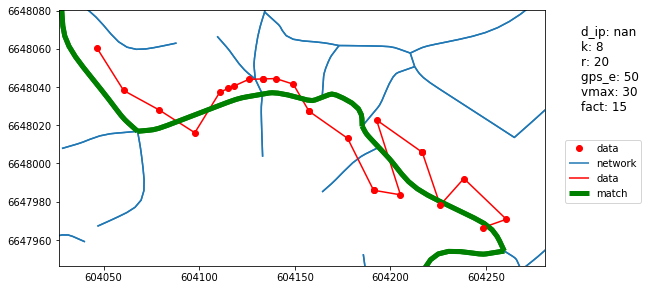

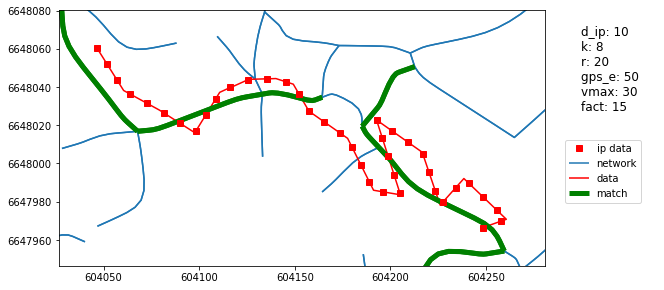

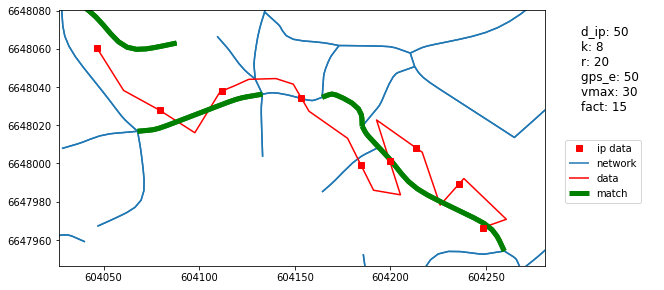

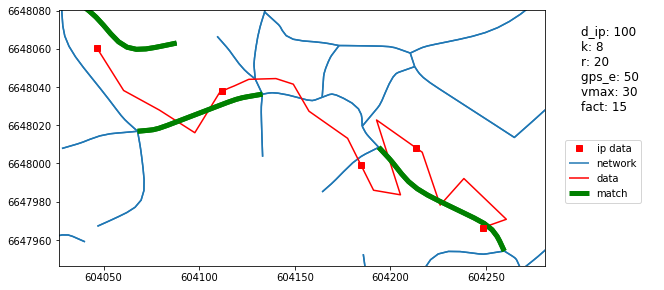

In [34]:
mm = mm_load(shp_)
for i in [0, 10, 50, 100]:
    mm = config_match_plot(mm, d=i, radius=radius, factor=factor, with_params=True) 

- Variation of the interpolation distance leads to missing links in the resulting track - __why?__
- All matches include reverse movements.
- The original data is matched best, but with reverse movements. 

## radius

In [35]:
d=0
k = 8
# radius=20
gps_e = 50
vmax = 30
factor=15

Vary the radius distance:

Loaded network: 210 nodes, 458 edges


/home/christianweber/programs/anaconda3/envs/py3fmm/lib/python3.8/site-packages/geopandas/plotting.py:529: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


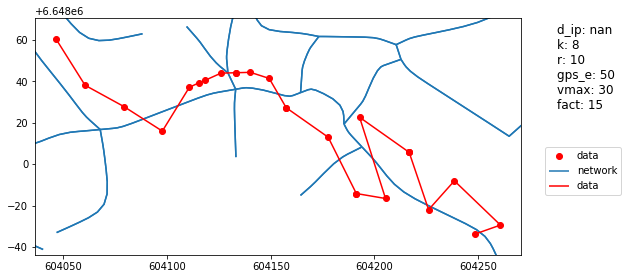

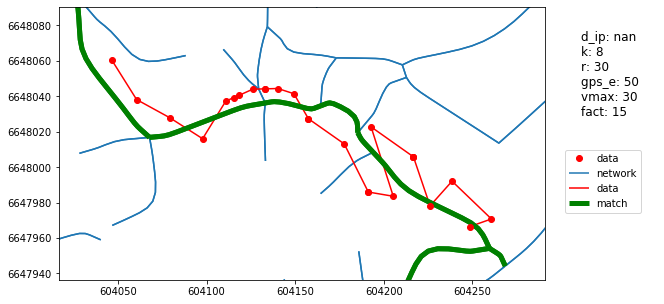

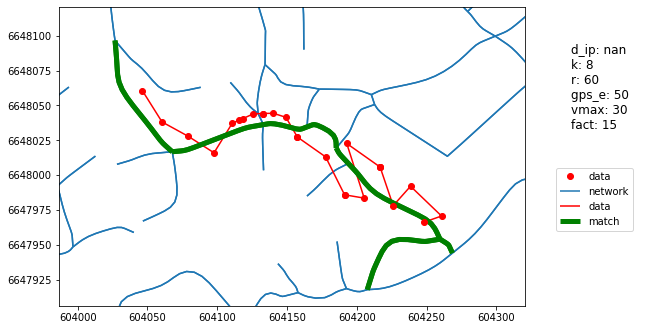

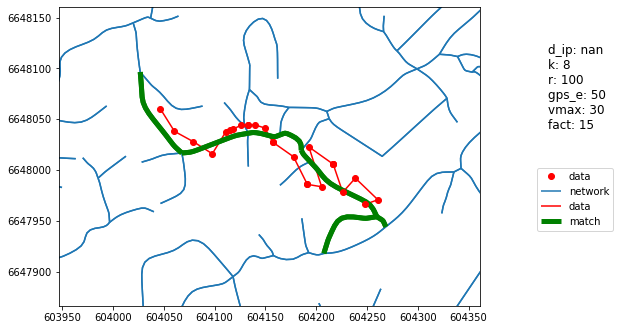

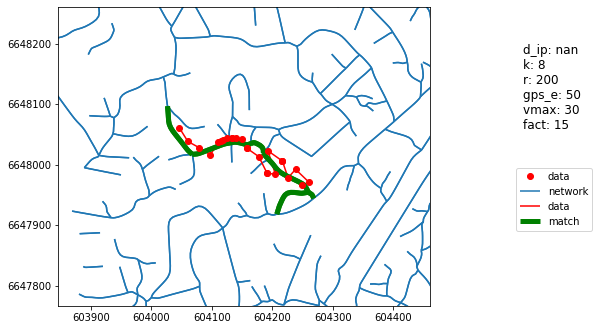

In [36]:
mm = mm_load(shp_)
for i in [10, 30, 60, 100, 200]:
    mm = config_match_plot(mm, d=d, radius=i, factor=factor, with_params=True) 

- If the radius is too small, no match is found (r=10)
- A radius of 30 matches these data well, but creates one reverse movement (r=30)
- All larger radii result in missing links - __why?__ (r>30)

## gps error

In [37]:
d=0
k = 8
radius=20
# gps_e = 50
vmax = 30
factor=15

Vary the interpolation distance:

Loaded network: 210 nodes, 458 edges


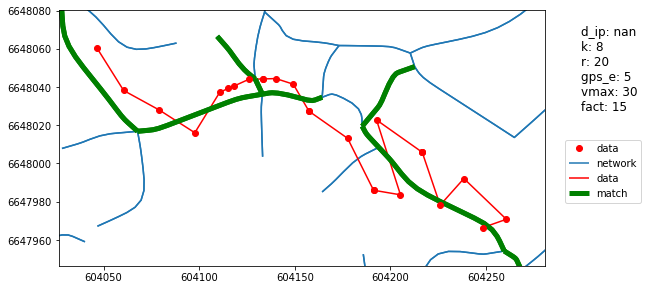

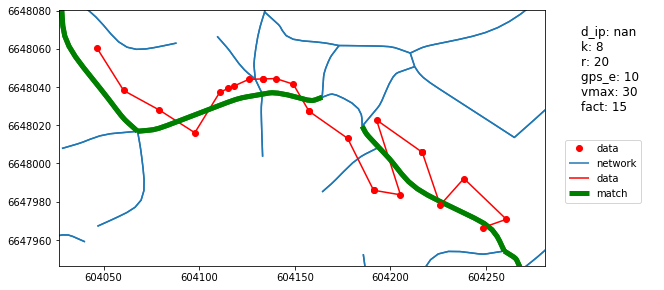

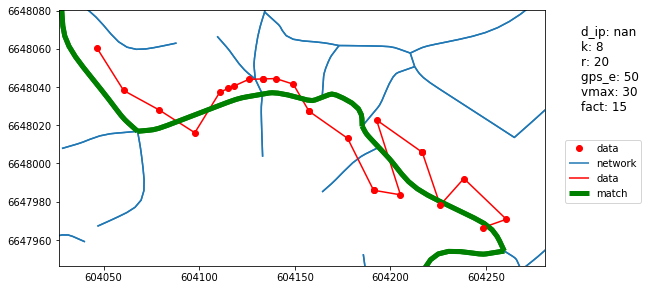

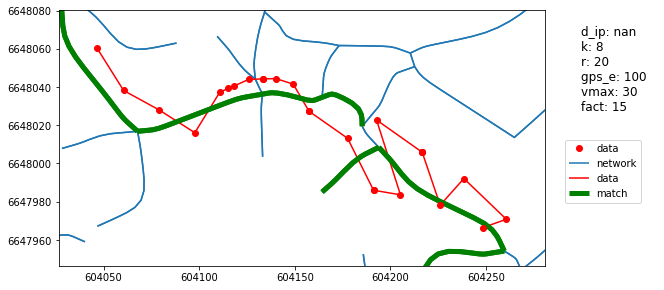

In [38]:
mm = mm_load(shp_)
for i in [5, 10, 50, 100]:
    mm = config_match_plot(mm, d=d, radius=radius, gps_error=i, with_params=True) 

- missing links for small gps errors (gps_e < 50)
- reverse movements in all cases

## factor

In [39]:
d=0
k = 8
radius=20
gps_e = 50
vmax = 30
# factor=15

Vary the factor:

Loaded network: 210 nodes, 458 edges


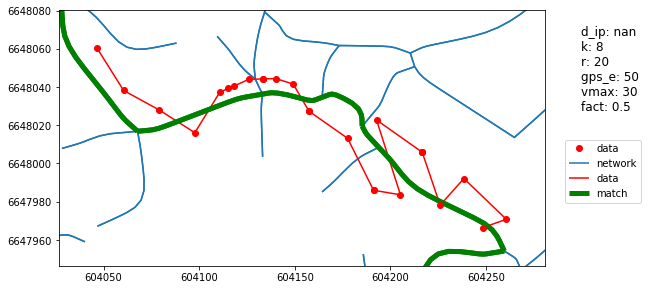

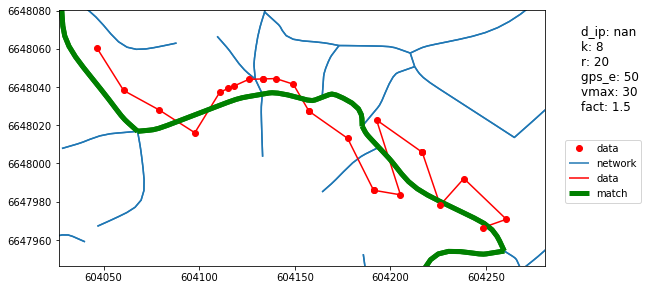

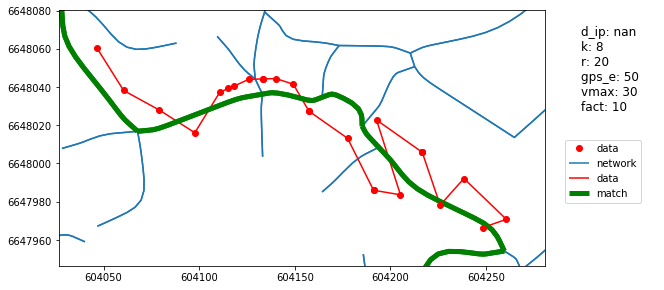

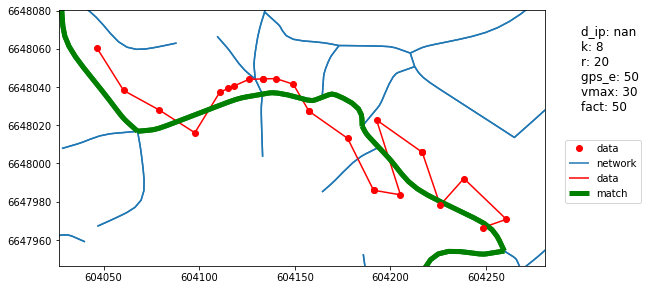

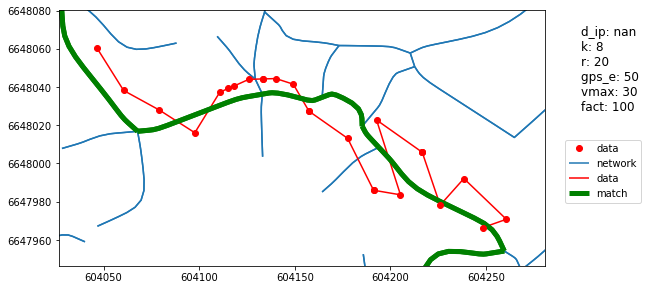

In [40]:
mm = mm_load(shp_)
for i in [0.5, 1.5, 10, 50, 100]:
    mm = config_match_plot(mm, d=d, radius=radius, factor=i, with_params=True) 

- The factor seems to have little influence in this example. All factors f > 0.5 result in connected matches
- reverse movement in all cases

## k

In [41]:
d=0
# k = 8
radius=20
gps_e = 50
vmax = 30
factor=15

Vary the number of candidates:

Loaded network: 210 nodes, 458 edges


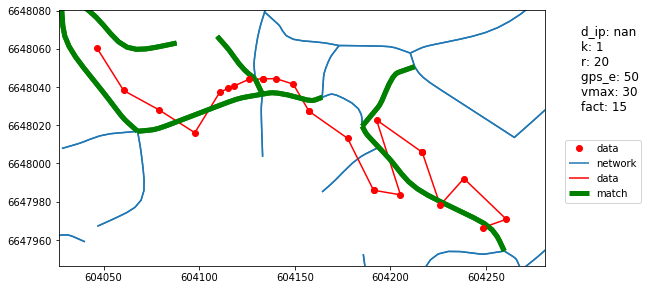

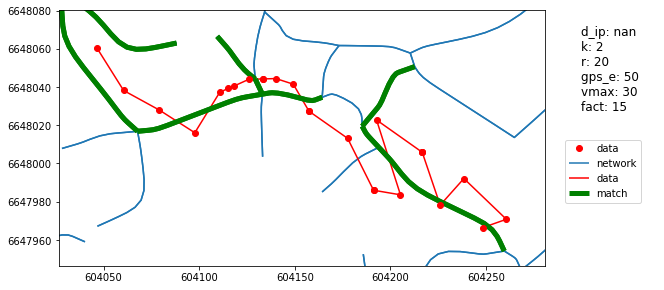

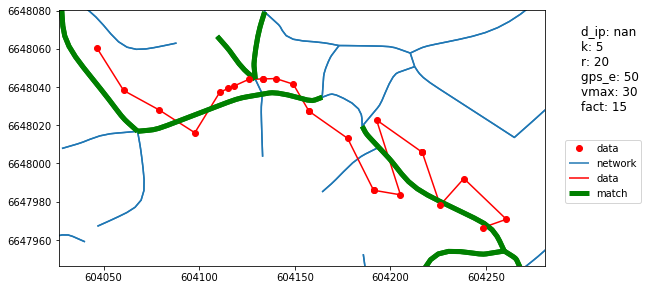

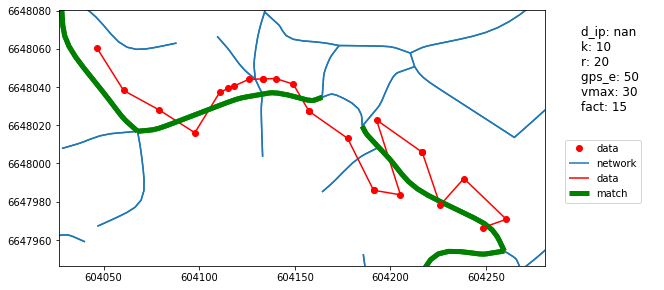

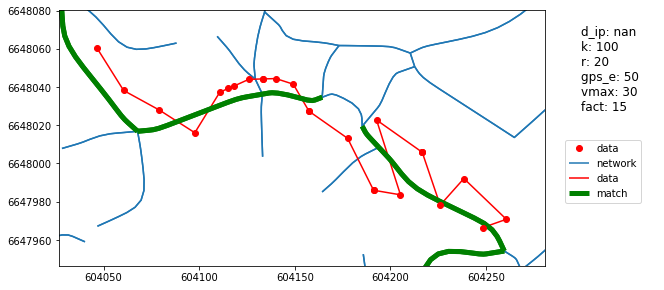

In [42]:
mm = mm_load(shp_)
for i in [1, 2, 5, 10, 100]:
    mm = config_match_plot(mm, k=i, d=d, radius=radius, factor=factor, with_params=True) 

- k <= 2 results in non-connected match
- k >= 5: connected matches with reverse movement
- k = 5 leads to the most links with reverse movement. 

# Questions

- What is the best way to tune the parameters? 
- Maybe build a minimizer around them? Some kind of gradient search?
- How can the reverse movements be avoided? -> use undirected network!
- Is there any paper available for the STMATCH algorithm? 
- In the FMM-paper, a penalty is mentioned for avoiding reverse movement. Is this still implemented? 
- Will FMM with a precalculated UBODT file give better results? 

are answered by cyang-kth here: https://github.com/cyang-kth/fmm/issues/70